In [379]:
import pandas as pd
import requests
import os
import json
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import TweetTokenizer
import string

bearer_token = 'AAAAAAAAAAAAAAAAAAAAALsfdAEAAAAAg5EP0Vrt%2BAyIksX0kDNaXrckI18%3DcVboUIsTTAdb9bTgWzXh5sCIUGFAFP4RswK5frgboOQgQEQKDa'

api_url = "https://api.twitter.com/"

query_params = {'query': '("sabesp") -is:retweet is:verified lang:pt','tweet.fields': 'author_id'}


def bearer_oauth(r):
    """
    Método exigido pela autenticação do token do portador.
    """

    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2RecentSearchPython"
    return r

def search_recent_tweets(query):
    response = requests.get(
        api_url + '2/tweets/search/recent', 
        auth=bearer_oauth, 
        params={
            "query": query,
            "max_results": 100,
            "tweet.fields":'author_id',
            "expansions":"author_id"
        }
    )

    if response.status_code != 200:
        raise Exception(response.status_code, response.text)

    return json.loads(response.text)

In [380]:
SEARCH_WORD = 'saneamento básico'
data = search_recent_tweets(f'("{SEARCH_WORD}") -is:retweet is:verified lang:pt')

In [381]:
PALAVRAS_REMOVER = [*stopwords.words('portuguese'), 'pra', 'tá', 'q', 'o', 'tô', 'água', 'brasil', 'águas']

In [382]:
def remove_PALAVRAS_REMOVER(text):
    new_text = ' '.join([k for k in text.split(" ") if k not in PALAVRAS_REMOVER])
    return new_text

In [383]:
dataframe = pd.DataFrame.from_dict(data['data'])
dataframeUser = pd.DataFrame.from_dict(data['includes']['users'])
df = dataframe.merge(dataframeUser, left_on='author_id', right_on='id')

In [384]:
def tratamento(text):
    text_sem_pontuacao = ''.join([p for p in text if p not in string.punctuation])
    text_sem_PALAVRAS_REMOVER = ' '.join([k for k in text_sem_pontuacao.lower().split(" ") if k not in PALAVRAS_REMOVER])
    text_formatado = ' '.join([k for k in text_sem_PALAVRAS_REMOVER.split(" ") if k.lower() not in SEARCH_WORD])
    text_formatado = ' '.join([k for k in text_formatado.split(" ") if not k.lower().startswith(SEARCH_WORD)])
    text_formatado = ' '.join([k for k in text_formatado.split(" ") if not k.lower().endswith(SEARCH_WORD)])
    return text_formatado.replace('\\n', '').replace('\n','').replace('\\','')

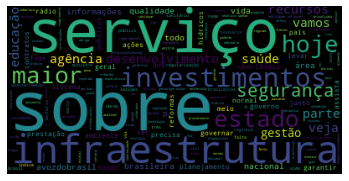

In [385]:
text = df['text'].map(tratamento).values 

wordcloud = WordCloud().generate(str(text))
#wordcloud.to_file('wordCloud.png')
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [386]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [387]:
df = pd.DataFrame(text, columns = ['TEXTO'])

In [388]:
for i in df.loc[:100, 'TEXTO']: print(i)

infraestrutura segurança hídrica mobilidade urbanização defesa civil frentes desenvolvimento fiz parte vamos sonhar juntos continuar trabalho tão importante esperado genterogeriotaon rogeriopelorn httpstco52z29votby
proposta aprovada obriga união garantir cumprimento convênios contratos estatal privatizada possuir junto entidades públicas áreas saúde educação meio ambiente infraestrutura ciência tecnologia veja httpstcoljrwvfw7gx
período poderão ser enviadas contribuições normativo procedimento geral comprovação adoção normas referência editadas agência parte agências infranacionais regulam serviços
webinário contará palestras especialista regulação recursos hídricos ana daniela chainho gerente planejamento recursos hídricos instituto mineiro gestão igam allan mota
governar difícil souber precisa governar povo elegeu normal país 3° maior produtor alimento mundo ter 33 milhões passando fome estado precisa levar cultura coisas básicas hoje estado leva
maior usina feita uberlândia lulaofi

In [389]:
s1 = "Britain’s trade will be much worse if it doesn’t have a good trade deal."
s2 = "Britain will have to abide by WTO rules if it doesn’t have a trade deal."
s3 = "Britain will be very successful whether or not it has a trade deal."

In [390]:
vs = analyzer.polarity_scores(s1)
print("{}… {}".format(s1[:30], str(vs)))
vs = analyzer.polarity_scores(s2)
print("{}… {}".format(s2[:30], str(vs)))
vs = analyzer.polarity_scores(s3)
print("{}… {}".format(s3[:30], str(vs)))

Britain’s trade will be much w… {'neg': 0.172, 'neu': 0.667, 'pos': 0.161, 'compound': -0.0516}
Britain will have to abide by … {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Britain will be very successfu… {'neg': 0.0, 'neu': 0.746, 'pos': 0.254, 'compound': 0.624}


In [391]:
dicionario_sentimentos = analyzer.polarity_scores(df['TEXTO'])
print(dicionario_sentimentos)

{'neg': 0.0, 'neu': 0.995, 'pos': 0.005, 'compound': 0.4019}


In [392]:
dicionario = {'sentimento': ['negativo', 'neutro', 'positivo', 'composta'], \
              'valores': [dicionario_sentimentos['neg'], \
                          dicionario_sentimentos['neu'], \
                          dicionario_sentimentos['pos'], \
                          dicionario_sentimentos['compound']]}

In [393]:
df_sentimentos = pd.DataFrame.from_dict(dicionario)
df_sentimentos.head()

,sentimento,valores
0,negativo,0.0000
1,neutro,0.9950
2,positivo,0.0050
3,composta,0.4019


# Inserir dados no azure usando Spark

In [394]:
#iniciar spark
from pyspark import SparkConf
from pyspark.sql import SparkSession

conf = SparkConf()
#conf.set('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:3.2.2')
conf.set('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:3.2.2,com.microsoft.azure:spark-mssql-connector_2.12:1.2.0')
conf.set("spark.jars", "/usr/share/java/mysql-connector-java-8.0.22.jar")
conf.set('spark.hadoop.fs.s3a.aws.credentials.provider', 'com.amazonaws.auth.InstanceProfileCredentialsProvider')

spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [395]:
_df = spark.createDataFrame(df)

_df.write \
 .format('com.microsoft.sqlserver.jdbc.spark') \
 .mode('overwrite') \
 .option('driver', 'com.microsoft.sqlserver.jdbc.SQLServerDriver') \
 .option('url', 'jdbc:sqlserver://server-water-quality.database.windows.net;databaseName=bd_water_quality;') \
 .option('dbtable', 'tbl_tweets_saneamento') \
 .option('user', 'urubu100') \
 .option('password', 'Urubu1@@') \
 .save()

22/06/15 02:18:49 INFO DefaultSource: JDBC Driver major/mior version 4  2
22/06/15 02:18:49 INFO SingleInstanceConnector: Overwriting without truncate for table 'tbl_tweets_saneamento'
22/06/15 02:18:49 INFO SingleInstanceWriteStrategies: write : best effort write to single instance called
22/06/15 02:18:49 INFO SparkContext: Starting job: foreachPartition at BestEffortSingleInstanceStrategy.scala:42
22/06/15 02:18:49 INFO DAGScheduler: Got job 26 (foreachPartition at BestEffortSingleInstanceStrategy.scala:42) with 2 output partitions
22/06/15 02:18:49 INFO DAGScheduler: Final stage: ResultStage 26 (foreachPartition at BestEffortSingleInstanceStrategy.scala:42)
22/06/15 02:18:49 INFO DAGScheduler: Parents of final stage: List()
22/06/15 02:18:49 INFO DAGScheduler: Missing parents: List()
22/06/15 02:18:49 INFO DAGScheduler: Submitting ResultStage 26 (MapPartitionsRDD[188] at rdd at BestEffortSingleInstanceStrategy.scala:42), which has no missing parents
22/06/15 02:18:49 INFO MemorySto

In [396]:
_df_sentimentos = spark.createDataFrame(df_sentimentos)

In [397]:
_df_sentimentos.printSchema()

root
 |-- sentimento: string (nullable = true)
 |-- valores: double (nullable = true)



In [398]:
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType, StringType, DoubleType, DecimalType

_df_sentimentos = _df_sentimentos.select(
    col('sentimento').cast(StringType()),
    col('valores').cast(DoubleType())
)

In [399]:
_df_sentimentos.show()

+----------+-------+
|sentimento|valores|
+----------+-------+
|  negativo|    0.0|
|    neutro|  0.995|
|  positivo|  0.005|
|  composta| 0.4019|
+----------+-------+



22/06/15 02:18:50 INFO SparkContext: Starting job: showString at NativeMethodAccessorImpl.java:0
22/06/15 02:18:50 INFO DAGScheduler: Got job 27 (showString at NativeMethodAccessorImpl.java:0) with 1 output partitions
22/06/15 02:18:50 INFO DAGScheduler: Final stage: ResultStage 27 (showString at NativeMethodAccessorImpl.java:0)
22/06/15 02:18:50 INFO DAGScheduler: Parents of final stage: List()
22/06/15 02:18:50 INFO DAGScheduler: Missing parents: List()
22/06/15 02:18:50 INFO DAGScheduler: Submitting ResultStage 27 (MapPartitionsRDD[195] at showString at NativeMethodAccessorImpl.java:0), which has no missing parents
22/06/15 02:18:50 INFO MemoryStore: Block broadcast_27 stored as values in memory (estimated size 12.3 KiB, free 434.4 MiB)
22/06/15 02:18:50 INFO MemoryStore: Block broadcast_27_piece0 stored as bytes in memory (estimated size 6.6 KiB, free 434.4 MiB)
22/06/15 02:18:50 INFO BlockManagerInfo: Added broadcast_27_piece0 in memory on ip-10-100-0-66.ec2.internal:40917 (size: 

In [400]:
_df_sentimentos.write \
 .format('com.microsoft.sqlserver.jdbc.spark') \
 .mode('overwrite') \
 .option('driver', 'com.microsoft.sqlserver.jdbc.SQLServerDriver') \
 .option('url', 'jdbc:sqlserver://server-water-quality.database.windows.net;databaseName=bd_water_quality;') \
 .option('dbtable', 'tbl_tweets_sentimentos') \
 .option('user', 'urubu100') \
 .option('password', 'Urubu1@@') \
 .save()

22/06/15 02:18:50 INFO DefaultSource: JDBC Driver major/mior version 4  2
22/06/15 02:18:50 INFO SingleInstanceConnector: Overwriting without truncate for table 'tbl_tweets_sentimentos'
22/06/15 02:18:50 INFO SingleInstanceWriteStrategies: write : best effort write to single instance called
22/06/15 02:18:50 INFO SparkContext: Starting job: foreachPartition at BestEffortSingleInstanceStrategy.scala:42
22/06/15 02:18:50 INFO DAGScheduler: Got job 29 (foreachPartition at BestEffortSingleInstanceStrategy.scala:42) with 2 output partitions
22/06/15 02:18:50 INFO DAGScheduler: Final stage: ResultStage 29 (foreachPartition at BestEffortSingleInstanceStrategy.scala:42)
22/06/15 02:18:50 INFO DAGScheduler: Parents of final stage: List()
22/06/15 02:18:50 INFO DAGScheduler: Missing parents: List()
22/06/15 02:18:50 INFO DAGScheduler: Submitting ResultStage 29 (MapPartitionsRDD[199] at rdd at BestEffortSingleInstanceStrategy.scala:42), which has no missing parents
22/06/15 02:18:50 INFO MemorySt